In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functools
from scipy import stats
from scopus_handler import ScopusHandler

def preprocess_authors(df):
    _column_name = "Author(s) ID"
    df = df.astype({_column_name: str})
    # nan, "[No author id available]"
    df = df[df[_column_name].notna()]
    df = df[df[_column_name] != "[No author id available]"]
    # Split by ;
    df = __set_num_authors(df)
    df = __set_first_author(df)
    df = __set_last_author(df)
    df = __set_list_authors(df)
    return df

def __set_num_authors(df):
    df["num_authors"] = df["Author(s) ID"].apply(lambda _text: len(_text.split(";")))
    return df

def __set_first_author(df):
    df["first_author"] = df["Author(s) ID"].apply(lambda _text: _text.split(";")[0])
    return df

def __set_last_author(df):
    df["last_author"] = df["Author(s) ID"].apply(lambda _text: _text.split(";")[-1])
    return df

def __set_list_authors(df):
    df["list_authors"] = df["Author(s) ID"].apply(lambda _text: _text.split(";"))
    return df

def preprocess_affiliations(df):
    _column_name = "Affiliations"
    df = df.astype({_column_name: str})
    # nan
    df = df[df[_column_name].notna()]
    # Split by ;
    df["num_affiliations"] = df[_column_name].apply(lambda _text: len(_text.split(";")))
    return df

def preprocess_funding(df):
    import math
    _column_name = "Funding Details"
    df["is_funded"] = df[_column_name].fillna(False)
    df["is_funded"] = df["is_funded"].apply(lambda _text: True if _text != False else _text)
#     df["is_funded"] = df[_column_name].apply(lambda _text: False if math.isnan(_text) else True)
    return df

def preprocess_access_type(df):
    _column_name = "Access Type"
    df["is_open"] = df[_column_name].fillna(False)
    df["is_open"] = df["is_open"].apply(lambda _text: True if _text != False else _text)
#     df["is_funded"] = df[_column_name].apply(lambda _text: False if math.isnan(_text) else True)
    return df

def preprocess_df(df):
    # 저자 수, 기관 수: 같은 수
    # 국제 집필 여부, 펀드 유무, 공개 논문 여부: 같은 여부
    # 동일 저널, 동일 문서 타입, 동일 토픽: 같은 분류
    df = df.drop_duplicates(subset=["DOI"])
    df = preprocess_authors(df)
    df = preprocess_affiliations(df)
    df = preprocess_funding(df)
    df = preprocess_access_type(df)
    return df

def get_filtering(target_scopus, df_counterparts, list_comparisons_equal=None, list_comparisons_isin_pairs=None):
    if type(list_comparisons_equal) != type(None):
        _filtering_equal = list(map(lambda _column_name: df_counterparts[_column_name].apply(lambda _text: _text == target_scopus[_column_name]), list_comparisons_equal))
    else:
        _filtering_equal = None
    # _filtering_isin = list(map(lambda _pair_column_names: target_scopus[_pair_column_names[0]].isin(df_counterparts[_pair_column_names[1]])))
    # _filtering_isin = list(map(lambda _pair_column_names: df_counterparts[_pair_column_names[0]].str.contains(target_scopus[_pair_column_names[1]]), list_comparisons_isin_pairs))
    if type(list_comparisons_isin_pairs) != type(None):
        _filtering_isin = list(map(lambda _pair_column_names: df_counterparts[_pair_column_names[0]].apply(lambda _list: target_scopus[_pair_column_names[1]] in _list),  # Get boolean
            list_comparisons_isin_pairs)
        )
    else:
        _filtering_isin = None


    # temp = pd.concat(
    #     _filtering_isin,
    #     axis=1
    # ).all(axis=1)
    # print(temp.value_counts())
    # exit()

    # _filtering = pd.concat(
    #     list(map(lambda _column_name: df_counterparts[_column_name] == target_scopus[_column_name] if _column_name not in comparisons_isin \
    #         else target_scopus[_column_name].isin(df_counterparts[_column_name]),
    #         list_comparisons)),
    #     axis=1
    # ).all(axis=1)
    if _filtering_equal != None and _filtering_isin != None:
        _filtering = pd.concat(
            _filtering_equal + _filtering_isin,
            axis=1
        ).all(axis=1)
        return _filtering
    elif _filtering_equal != None:
        _filtering = pd.concat(
            _filtering_equal,
            axis=1
        ).all(axis=1)
        return _filtering
    elif _filtering_isin != None:
        _filtering = pd.concat(
            _filtering_isin,
            axis=1
        ).all(axis=1)
        return _filtering
    else:
        raise ValueError("Both list_comparisons_equal and list_comparisons_isin_pairs are None.")

def get_pairs(df, df_sources, scopus_handler, m=3, num_comparisons=6, max_num_trial=6, metric="Cited by", log_scale=True):
    # 1:m matching

    _list_pairs = list()
    # _list_comparisons = [
    #     "is_open",
    #     # "num_authors",
    #     # "num_affiliations",
    #     "first_author",
    #     "last_author",
    #     "is_funded",
    #     "Document Type",
    #     "Source title",  # First priority
    # ][-num_comparisons:]
    _list_comparisons_equal = [
        # "is_open",
        # "num_authors",
        # "num_affiliations",
        # "first_author",
        "last_author",
        "is_funded",
        "Document Type",
        "Source title",  # First priority
    ][-num_comparisons:]
    _list_comparisons_isin_pairs = [
        ("list_authors", "first_author")  # (Counterparts, Target)
    ]
    dict_scopus_by_trial = dict()
    dict_scopus_by_trial["out"] = list()
    for _i in range(max_num_trial):
        dict_scopus_by_trial[_i] = list()

    _set_dois = set(map(lambda _tup_video: _tup_video[2], scopus_handler.set_target_videos().list_target_videos))
    # print("!HERE!")
    # print(len(_set_dois))
    # return
    # _set_dois = set(map(lambda _tup_video: _tup_video[2], scopus_handler.set_target_videos(where=("content", ("paper_explanation", "paper_assessment", "paper_application"), "in")).list_target_videos))

    df = preprocess_df(df)
    if log_scale:
        df = df.dropna(subset=[metric])
        df = df[df[metric] != "None"]
    # Exclude target DOIs
    df_target_dois = df[df["DOI"].isin(_set_dois)]
    df_counterparts = df[~df["DOI"].isin(_set_dois)]

    for _i, (_idx, _target_scopus) in enumerate(df_target_dois.iterrows()):
        print("[+]Processing %d of %d..." % (_i + 1, len(df_target_dois)))
    #     print(_target_scopus)
    #     _filtering = pd.concat([
    #         df3["num_authors"] == _target_scopus["num_authors"],
    #         df3["num_affiliations"] == _target_scopus["num_affiliations"],
    #         df3["is_funded"] == _target_scopus["is_funded"],
    #         df3["is_open"] == _target_scopus["is_open"],
    #         df3["Source title"] == _target_scopus["Source title"],
    #         df3["Document Type"] == _target_scopus["Document Type"],
    #     ], axis=1).all(axis=1)
        _num_trial = 0
        while True:
            print(f"\t[+]{_num_trial + 1} th trial.")
            # _filtering = get_filtering(_target_scopus, df_counterparts, _list_comparisons_equal[_num_trial:], _list_comparisons_isin_pairs)
            _filtering = get_filtering(_target_scopus, df_counterparts, _list_comparisons_equal[_num_trial:])
            # Randomly sample m matchers
            try:
                _scopus_counterparts = df_counterparts.loc[df_counterparts[_filtering].sample(m).index]
            except ValueError:  # sample larger than population
                print("\t[-]Sample larger than population\n\tDOI: %s\tPopulation: %d\n\tRetrying..." % (_target_scopus["DOI"], len(df_counterparts[_filtering])))
                # _scopus_counterparts = df[_filtering]
                _num_trial += 1
                if _num_trial == max_num_trial:
                    print("\t[-]Reached max_num_trial. Continue to next target_scopus.")
                    dict_scopus_by_trial["out"].append(_target_scopus)
                    break
            else:
                # Append to list
                _list_pairs.append((_target_scopus, _scopus_counterparts))
                dict_scopus_by_trial[_num_trial].append(_target_scopus)
                # Drop samples from original df
                df_counterparts = df_counterparts.drop(_scopus_counterparts.index)
                break
    return (_list_pairs, dict_scopus_by_trial)

def get_metric_pairs(df, df_sources, scopus_handler, m=3, num_comparisons=6, max_num_trial=6, metric="Cited by", log_scale=True):
    (_list_pairs, _dict_scopus_by_trial) = get_pairs(df, df_sources, scopus_handler, m=m, num_comparisons=num_comparisons, max_num_trial=max_num_trial, metric=metric, log_scale=log_scale)
    _meters_targets = list(map(lambda _pair: int(np.nan_to_num(_pair[0][metric])), _list_pairs))
    _meters_counterparts = functools.reduce(lambda a, b: a + b, list(map(lambda _twin: list(np.nan_to_num(_twin[1][metric].astype(int).values)), _list_pairs)))
    # print(_meters_counterparts)
    if log_scale:
        _meters_targets = np.log10(_meters_targets)
        _meters_counterparts = np.log10(_meters_counterparts)
    return (_meters_counterparts, _meters_targets, _dict_scopus_by_trial)

def get_corr(df, df_sources, scopus_handler, m=3, num_comparisons=6, max_num_trial=6, list_metrics=["num_affiliations", "Cited by"], list_log_scale=[False, True]):
    _list_meters_targets = list()
    _list_meters_counterparts = list()
    (_list_pairs, _dict_scopus_by_trial) = get_pairs(df, df_sources, scopus_handler, m=m, num_comparisons=num_comparisons, max_num_trial=max_num_trial, metric=list_metrics[1], log_scale=list_log_scale[1])
    # print(_list_pairs)
    for _i in range(2):
        _metrics_targets = list(map(lambda _pair: int(np.nan_to_num(_pair[0][list_metrics[_i]])), _list_pairs))
        _metrics_counterparts = functools.reduce(lambda a, b: a + b, list(map(lambda _pair: list(np.nan_to_num(_pair[1][list_metrics[_i]].astype(int).values)), _list_pairs)))

        if list_log_scale[_i]:
            _metrics_targets = np.log10(_metrics_targets)
            _metrics_counterparts = np.log10(_metrics_counterparts)

        _list_meters_targets.append(_metrics_targets)
        _list_meters_counterparts.append(_metrics_counterparts)

    def plot_scatter(list_meters, list_metrics, list_log_scale):
        # print("[+]Plot counterparts")
        plt.ylabel(list_metrics[0]) if list_log_scale[0] else plt.ylabel(f"log10{list_metrics[0]}")
        plt.ylabel(list_metrics[1]) if list_log_scale[1] else plt.ylabel(f"log10{list_metrics[1]}")
        plt.scatter(list_meters[0], list_meters[1])
        plt.show()

    plot_scatter(_list_meters_counterparts, list_metrics, list_log_scale)
    plot_scatter(_list_meters_targets, list_metrics, list_log_scale)        

[+]Duplicates have been dropped from df_scopus.	Before: 9598	After: 9336
!HERE!
Total videos: 148
# Total DOIs: 9336	# DOIs w/ videos: 102	Ratio: 0.011
# Total videos: 143	# Target videos: 143	Ratio: 1.000
# Total subjects: 43	# subjects w/ videos: 24	Ratio: 0.558
# Total journals: 133	# journals w/ videos: 35	Ratio: 0.263
[+]Processing 1 of 100...
	[+]1 th trial.
[+]Processing 2 of 100...
	[+]1 th trial.
[+]Processing 3 of 100...
	[+]1 th trial.
[+]Processing 4 of 100...
	[+]1 th trial.
[+]Processing 5 of 100...
	[+]1 th trial.
[+]Processing 6 of 100...
	[+]1 th trial.
[+]Processing 7 of 100...
	[+]1 th trial.
[+]Processing 8 of 100...
	[+]1 th trial.
[+]Processing 9 of 100...
	[+]1 th trial.
[+]Processing 10 of 100...
	[+]1 th trial.
[+]Processing 11 of 100...
	[+]1 th trial.
[+]Processing 12 of 100...
	[+]1 th trial.
[+]Processing 13 of 100...
	[+]1 th trial.
[+]Processing 14 of 100...
	[+]1 th trial.
[+]Processing 15 of 100...
	[+]1 th trial.
[+]Processing 16 of 100...
	[+]1 th tri

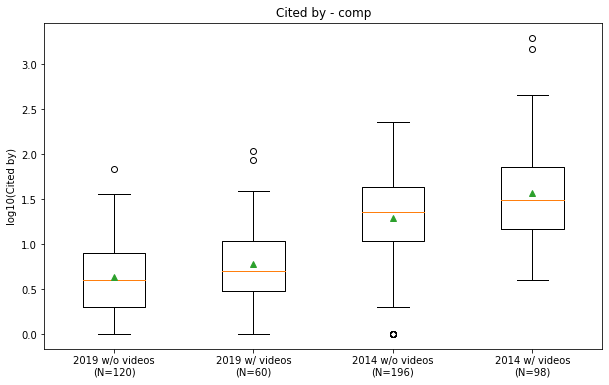

In [2]:
subject="comp"
m=2
num_comparisons=4
max_num_trial=1
metric="Cited by"
log_scale=True
# list_metrics=["num_affiliations", "Cited by"]
# list_log_scale=[False, True]

# df1 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_2019_comp.csv")
# df1_sources = pd.read_csv("scopus/source_2018_comp.csv", header=0)
# scopus_2019_comp = ScopusHandler(df1, df1_sources, "scopus_videos_2019_comp", verbose=False)
# df3 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_2014_comp.csv")
# df3_sources = pd.read_csv("scopus/source_2013_comp.csv", header=0)
# scopus_2014_comp = ScopusHandler(df3, df3_sources, "scopus_videos_2014_comp", verbose=False)
# _2019_wo_videos_cit, _2019_w_videos_cit, _2019_dict_scopus_by_trial = get_pairs(df1, df1_sources, scopus_2019_comp, m=m, num_comparisons=num_comparisons, max_num_trial=max_num_trial, metric=metric, log_scale=log_scale)
# _2014_wo_videos_cit, _2014_w_videos_cit, _2014_dict_scopus_by_trial = get_pairs(df3, df3_sources, scopus_2014_comp, m=m, num_comparisons=num_comparisons, max_num_trial=max_num_trial, metric=metric, log_scale=log_scale)

df4 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_2014_%s.csv" % subject)
df4_sources = pd.read_csv("scopus/source_2013_%s.csv" % subject, header=0)
scopus_2014_life = ScopusHandler(df4, df4_sources, "scopus_videos_2014_%s" % subject, verbose=False)
# get_corr(df4, df4_sources, scopus_2014_life, m=m, num_comparisons=num_comparisons, max_num_trial=max_num_trial, list_metrics=list_metrics, list_log_scale=list_log_scale)
_2014_wo_videos_cit, _2014_w_videos_cit, _2014_dict_scopus_by_trial = get_metric_pairs(df4, df4_sources, scopus_2014_life, m=m, num_comparisons=num_comparisons, max_num_trial=max_num_trial, metric=metric, log_scale=log_scale)

df2 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_2019_%s.csv" % subject)
df2_sources = pd.read_csv("scopus/source_2018_%s.csv" % subject, header=0)
scopus_2019_life = ScopusHandler(df2, df2_sources, "scopus_videos_2019_%s" % subject, verbose=False)
_2019_wo_videos_cit, _2019_w_videos_cit, _2019_dict_scopus_by_trial = get_metric_pairs(df2, df2_sources, scopus_2019_life, m=m, num_comparisons=num_comparisons, max_num_trial=max_num_trial, metric=metric, log_scale=log_scale)

for _i in _2019_dict_scopus_by_trial:
    print("%s trial(s): %d" % (_i, len(_2019_dict_scopus_by_trial[_i])))
for _i in _2014_dict_scopus_by_trial:
    print("%s trial(s): %d" % (_i, len(_2014_dict_scopus_by_trial[_i])))
print("2019")
print(np.mean(_2019_wo_videos_cit), np.mean(_2019_w_videos_cit))
print(stats.ttest_ind(_2019_wo_videos_cit, _2019_w_videos_cit))
print("2014")
print(np.mean(_2014_wo_videos_cit), np.mean(_2014_w_videos_cit))
print(stats.ttest_ind(_2014_wo_videos_cit, _2014_w_videos_cit))

plt.figure(figsize=(10, 6))
# plt.ylim(-0.2, 3.5)
plt.title(f"{metric} - {subject}")
# plt.yscale("log")
# plt.ylim([0, 200])
plt.ylabel(f"log10({metric})")
plt.boxplot([
        _2019_wo_videos_cit,
        _2019_w_videos_cit,
        _2014_wo_videos_cit,
        _2014_w_videos_cit
    ],
    labels=[
        "2019 w/o videos\n(N=%s)"%len(_2019_wo_videos_cit),
        "2019 w/ videos\n(N=%s)"%len(_2019_w_videos_cit),
        "2014 w/o videos\n(N=%s)"%len(_2014_wo_videos_cit),
        "2014 w/ videos\n(N=%s)"%len(_2014_w_videos_cit)
    ],
    showmeans=True
)
plt.show()

In [6]:
from scipy.stats import shapiro , normaltest , anderson , kstest , zscore , iqr
outlier_threshold = 1.5

# _2019_wo_videos_cit
# _2019_w_videos_cit
# _2014_wo_videos_cit
# _2014_w_videos_cit

S1 = pd.Series(_2014_w_videos_cit)
_iqr1 = iqr(S1)
S1 = S1[S1.between(S1.quantile(0.25) - outlier_threshold * _iqr1, S1.quantile(0.75) + outlier_threshold * _iqr1)]
# S2 = pd.Series(_2014_w_videos_cit)
# _iqr2 = iqr(S2)
# S2 = S2[S2.between(S2.quantile(0.25) - outlier_threshold * _iqr2, S2.quantile(0.75) + outlier_threshold * _iqr2)]

stat, p  = normaltest(S1)
# stat, p  = shapiro(S)
# stat, p = kstest(S1, S2)
alpha = 0.05
print(f"p = {p}")
if p > alpha :
    print("Normal.")
else :
    print("NOT normal.")

p = 0.07429708708268189
Normal.
